<a href="https://colab.research.google.com/github/fauk74/Machine-Learning/blob/main/NLP_kaggle_tensorflow_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NLP : Kaggle Competition Disaster Tweets

In [1]:
!nvidia-smi -L


GPU 0: Tesla K80 (UUID: GPU-624a96e1-639f-6e15-70d1-9212ce20fee2)


In [2]:
!wget https://raw.githubusercontent.com/fauk74/Data-Visualization-and-Utility/main/helper_functions.py

--2021-10-21 03:13:28--  https://raw.githubusercontent.com/fauk74/Data-Visualization-and-Utility/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15186 (15K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  14.83K  --.-KB/s    in 0s      

2021-10-21 03:13:29 (66.7 MB/s) - ‘helper_functions.py’ saved [15186/15186]



In [3]:

#!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [4]:
from helper_functions import create_tensorboard_callback , plot_loss_curves, unzip_data, walk_through_dir,  calculate_results

In [5]:
import os
os.environ['KAGGLE_USERNAME'] = "faustorenda"
os.environ['KAGGLE_KEY'] = "5fb663b0362c20c1fadff51883752546"
!kaggle competitions download -c nlp-getting-started



  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 63.7MB/s]
  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 56.9MB/s]
  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 22.1MB/s]


In [6]:
#Download the Kaggle nlp file competition alternative
#!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
#unzip_data('nlp_getting_started.zip')

In [7]:
from helper_functions import create_tensorboard_callback

#Create a directory for tensorboard

SAVE_DIR="model_logs"


In [8]:
import pandas as pd
train_df=pd.read_csv("train.csv")
test_df=pd.read_csv("test.csv")


In [9]:
train_df_shuffled=train_df.sample(frac=1,random_state=42)


In [10]:
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [11]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [12]:
#let's visualize some random training 
import random 
random_index = random.randint(0, len(train_df)-5)# create random indexes 

for row in train_df_shuffled[["text","target"]][random_index:random_index+5].itertuples():
  _, text,target=row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("----\n")


Target: 0 (not real disaster)
Text:
I just wanna smoke some weed and get some commas

----

Target: 0 (not real disaster)
Text:
Are people not concerned that after #SLAB's obliteration in Scotland #Labour UK is ripping itself apart over #Labourleadership contest?

----

Target: 0 (not real disaster)
Text:
2/his explanation was that 'you request as much as you want provided you get your job done but you're constantly drowning in work!'

----

Target: 0 (not real disaster)
Text:
The Hobbit: The Desolation of Smaug - Ed Sheeran 'I See Fire' [HD] http://t.co/OXRwRJZmnu

----

Target: 0 (not real disaster)
Text:
@Limpar33 sweeping legs? Or putting people in body bags?

----



In [13]:
train_df_shuffled["text"].to_numpy()

array(['So you have a new weapon that can cause un-imaginable destruction.',
       'The f$&amp;@ing things I do for #GISHWHES Just got soaked in a deluge going for pads and tampons. Thx @mishacollins @/@',
       'DT @georgegalloway: RT @Galloway4Mayor: \x89ÛÏThe CoL police can catch a pickpocket in Liverpool Stree... http://t.co/vXIn1gOq4Q',
       ...,
       'Omron HEM-712C Automatic Blood Pressure Monitor STANDARD AND LARGE BP CUFFS http://t.co/gJBAInQWN9 http://t.co/jPhgpL1c5x',
       'Officials say a quarantine is in place at an Alabama home over a possible Ebola case after developing symptoms... http://t.co/rqKK15uhEY',
       'I moved to England five years ago today. What a whirlwind of time it has been! http://t.co/eaSlGeA1B7'],
      dtype=object)

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
#Train
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)

In [16]:
len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(6851, 762, 6851, 762)

In [17]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [18]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer=TextVectorization(max_tokens=10000,
                                  standardize="lower_and_strip_punctuation",
                                  split="whitespace",
                                  ngrams=None,
                                  output_mode="int",
                                  output_sequence_length=None,
                                  pad_to_max_tokens=True)

In [19]:
len(train_sentences)

6851

In [20]:
(sum([len(i.split()) for i in train_sentences]))/len(train_sentences)

14.901036345059115

In [21]:
#Text Vectorization
max_vocab_length=10000
max_length=15
text_vectorizer=TextVectorization(max_tokens=max_vocab_length,
                                  output_mode="int",
                                  output_sequence_length=max_length)

In [22]:
text_vectorizer.adapt(train_sentences)

In [23]:
sample_sentence="There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [24]:
random_sentence=random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
        \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
 He's being put on a stretcher ?? don't want to see that.        

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[277, 121, 370,  11,   3, 725,  63, 138,   5,  99,  16,   0,   0,
          0,   0]])>

In [25]:
words_in_vocab=text_vectorizer.get_vocabulary()
top_5_words=words_in_vocab[:5]
bottom_5_words=words_in_vocab[-5:]

print(len(words_in_vocab), "\n", top_5_words, "\n", bottom_5_words)

10000 
 ['', '[UNK]', 'the', 'a', 'in'] 
 ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [26]:
### Create an Embedding Layer
from tensorflow.keras import layers 

embedding=layers.Embedding(input_dim=max_vocab_length,
                           output_dim=128,
                           embeddings_initializer="uniform",
                           input_length=max_length)

In [27]:
random_sentence=random.choice(train_sentences)
print(random_sentence)
sample_embed=embedding(text_vectorizer([random_sentence]))
sample_embed


Mortal Kombat X is an excellent fatalities and the most fun IÛªve ever had with a mortal kombat SEGA's version http://t.co/fLO8fgy35A


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.03311827,  0.01082508, -0.0292679 , ...,  0.03926509,
         -0.00143011,  0.04974235],
        [ 0.0486973 , -0.01239998,  0.01847893, ..., -0.04316187,
         -0.02380266, -0.02332904],
        [-0.03190961,  0.02216138, -0.0393522 , ..., -0.03236387,
          0.02246884,  0.03486342],
        ...,
        [ 0.02173379, -0.04083351, -0.00423918, ...,  0.00417455,
          0.0135189 , -0.04476487],
        [-0.00375615,  0.01034258, -0.04336276, ..., -0.03684806,
          0.03881264,  0.02288255],
        [-0.0225926 ,  0.00648845,  0.01922853, ..., -0.00322599,
          0.0486044 , -0.03110323]]], dtype=float32)>

In [28]:
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 0.03311827,  0.01082508, -0.0292679 ,  0.02149632,  0.01597103,
       -0.03732725,  0.02733665,  0.04463068,  0.01177058, -0.02378519,
        0.04023968, -0.02982971,  0.04154265,  0.01100605,  0.02898291,
        0.02655038,  0.01909909,  0.03038833,  0.045773  , -0.02896436,
        0.00626736,  0.01218197,  0.03498385, -0.04798364,  0.01037866,
       -0.01102767,  0.04903162, -0.01687795, -0.04350555,  0.04254563,
        0.01524086,  0.02219303,  0.00858787,  0.03435545,  0.00246422,
        0.00216013,  0.04674404,  0.03507347,  0.02274462,  0.01471299,
       -0.04726307, -0.00422511, -0.00712963,  0.0082751 ,  0.04513827,
       -0.04210107,  0.04300017,  0.03470543,  0.04124788,  0.0053014 ,
        0.03223905, -0.00228784,  0.02467581, -0.04128449, -0.03112167,
       -0.0106103 , -0.0090246 , -0.01775218, -0.03632899,  0.00319874,
       -0.01423983,  0.02979592, -0.03503251, -0.01246087,  0.03604293,
       -0.042689

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline


In [30]:
model_0=Pipeline([
                  ("tfidf", TfidfVectorizer()),
                  ("clf", MultinomialNB())
])

In [31]:
model_0.fit(train_sentences, train_labels)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [32]:
#Evaluate our baseline model 
baseline_score=model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of:{baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of:79.27%


In [33]:
baseline_preds=model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [34]:
from sklearn.metrics import accuracy_score, f1_score , precision_recall_fscore_support
print(f1_score(val_labels, baseline_preds,average='weighted'),
f1_score(val_labels, baseline_preds,average='micro'),
f1_score(val_labels, baseline_preds,average='macro'),)

0.7862189758049549 0.7926509186351706 0.7820571304442272


In [35]:
baseline_results=calculate_results(y_true=val_labels, y_pred=baseline_preds)

In [36]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [37]:
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.
  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"
  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [38]:
from tensorflow.keras import layers
inputs=layers.Input(shape=(1,), dtype=tf.string)
x=text_vectorizer(inputs)
x=embedding(x)
x=layers.GlobalAveragePooling1D()(x) #condense the feature vector optherwise we'll have a vector 15 
outputs=layers.Dense(1,activation="sigmoid")(x)
model_1=tf.keras.Model(inputs, outputs, name="model_1_dense")

In [39]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [40]:
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])



In [41]:
model_1_history=model_1.fit(x=train_sentences,
                           y=train_labels,
                           epochs=5,
                           validation_data=(val_sentences, val_labels),
                           callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                      experiment_name= "model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20211021-031344
Epoch 1/5
215/215 [==============================] - 5s 9ms/step - loss: 0.6126 - accuracy: 0.6881 - val_loss: 0.5359 - val_accuracy: 0.7546
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.4405 - accuracy: 0.8171 - val_loss: 0.4724 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 1s 7ms/step - loss: 0.3463 - accuracy: 0.8631 - val_loss: 0.4615 - val_accuracy: 0.7940
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2837 - accuracy: 0.8902 - val_loss: 0.4635 - val_accuracy: 0.7822
Epoch 5/5
215/215 [==============================] - 1s 7ms/step - loss: 0.2366 - accuracy: 0.9113 - val_loss: 0.4776 - val_accuracy: 0.7769


In [42]:
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 0.4776 - accuracy: 0.7769


[0.4775606095790863, 0.7769029140472412]

In [43]:
model_1_pre_probs=model_1.predict(val_sentences)
model_1_pre_probs.shape
model_1_preds = tf.squeeze(tf.round(model_1_pre_probs)) # squeeze removes single dimen
model_1_results=calculate_results(y_true=val_labels, y_pred=model_1_preds)

In [44]:
model_1_pre_probs[0]

array([0.43390083], dtype=float32)

In [45]:
inputs=layers.Input(shape=(1,), dtype=tf.string)
x=text_vectorizer(inputs)
x=embedding(x)
x=layers.GlobalMaxPooling1D()(x) #condense the feature vector optherwise we'll have a vector 15 
outputs=layers.Dense(1,activation="sigmoid")(x)
model_2=tf.keras.Model(inputs, outputs, name="model_1_dense")
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [46]:
model_2_history=model_1.fit(x=train_sentences,
                           y=train_labels,
                           epochs=5,
                           validation_data=(val_sentences, val_labels),
                           callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                      experiment_name= "model_2_dense")])

Saving TensorBoard log files to: model_logs/model_2_dense/20211021-031356
Epoch 1/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2009 - accuracy: 0.9283 - val_loss: 0.5009 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1722 - accuracy: 0.9402 - val_loss: 0.5248 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1494 - accuracy: 0.9494 - val_loss: 0.5577 - val_accuracy: 0.7782
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1299 - accuracy: 0.9572 - val_loss: 0.5820 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1159 - accuracy: 0.9616 - val_loss: 0.6125 - val_accuracy: 0.7782


In [47]:
model_1_preds=tf.squeeze(tf.round(model_1_pre_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [48]:
model_1_results=calculate_results(y_true=val_labels, y_pred=model_1_preds)

In [49]:
model_1_results

{'accuracy': 77.69028871391076,
 'f1': 0.7747522807746444,
 'precision': 0.7789562668302826,
 'recall': 0.7769028871391076}

In [50]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

## Visualizing Learned Embedding

In [51]:
words_in_vocab=text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [52]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [53]:
#Get the matrix embedding layer, the numerical representation in our training data
embed_weights=model_1.get_layer("embedding").get_weights()[0]

In [54]:
print(embed_weights.shape)

(10000, 128)


In [55]:
#Create embedding files
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [56]:
#Download files
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [57]:
len(val_labels), len(val_sentences)


(762, 762)

In [58]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [59]:
# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [60]:
# Fit model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20211021-031405
Epoch 1/5
215/215 [==============================] - 7s 14ms/step - loss: 0.5100 - accuracy: 0.7416 - val_loss: 0.4566 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3176 - accuracy: 0.8717 - val_loss: 0.5138 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2201 - accuracy: 0.9152 - val_loss: 0.5858 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1556 - accuracy: 0.9428 - val_loss: 0.6041 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1076 - accuracy: 0.9594 - val_loss: 0.8746 - val_accuracy: 0.7507


In [61]:
model_2_pred_probs=model_2.predict(val_sentences)
model_2_preds=tf.squeeze(tf.round(model_2_pred_probs))
model_2_results=calculate_results(y_true=val_labels,
                                  y_pred=model_2_preds)

In [62]:
model_2_results

{'accuracy': 75.06561679790026,
 'f1': 0.7489268622514025,
 'precision': 0.7510077975908164,
 'recall': 0.7506561679790026}

In [63]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

# Build RNN using a GRU cell

In [64]:
from tensorflow.keras import layers
inputs=layers.Input(shape=(1,), dtype=tf.string)
x=text_vectorizer(inputs)
x=embedding(x)

#x=layers.GRU(64,return_sequences=True)(x)
x=layers.GRU(64)(x)

#x=layers.GlobalAveragePooling1D()(x)
outputs=layers.Dense(1,activation="sigmoid")(x)
model_3=tf.keras.Model(inputs,outputs, name="model_3_GRU")


In [65]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
gru (GRU)                    (None, 64)                37248     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_________________________________________________________________


In [66]:
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_3_history=model_3.fit(train_sentences,
                            train_labels,
                            epochs=5,
                            validation_data=(val_sentences, val_labels),
                            callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                   "model_GRU")])

Saving TensorBoard log files to: model_logs/model_GRU/20211021-031422
Epoch 1/5
215/215 [==============================] - 5s 14ms/step - loss: 0.1607 - accuracy: 0.9358 - val_loss: 0.6482 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0920 - accuracy: 0.9666 - val_loss: 0.7271 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0784 - accuracy: 0.9704 - val_loss: 0.9141 - val_accuracy: 0.7808
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0742 - accuracy: 0.9720 - val_loss: 0.9104 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0668 - accuracy: 0.9729 - val_loss: 0.8717 - val_accuracy: 0.7782


In [67]:
model_3_pred_probs=model_3.predict(val_sentences)
model_3_preds=tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [68]:
model_3_results=calculate_results(y_true=val_labels,
                                  y_pred=model_3_preds)
model_3_results

{'accuracy': 77.82152230971128,
 'f1': 0.7766208088282468,
 'precision': 0.7791991586469295,
 'recall': 0.7782152230971129}

# Experiment

In [69]:


from tensorflow.keras import layers
inputs=layers.Input(shape=(1,), dtype=tf.string)
x=text_vectorizer(inputs)
x=embedding(x)

#x=layers.GRU(64,return_sequences=True)(x)
x=layers.GRU(64, return_sequences=True)(x)
x=layers.LSTM(64,return_sequences=True)(x)
x=layers.GlobalAveragePooling1D()(x)
outputs=layers.Dense(1,activation="sigmoid")(x)
model_3_ex=tf.keras.Model(inputs,outputs, name="model_3ex_GRU+LSTM")

In [70]:
model_3_ex.summary()

Model: "model_3ex_GRU+LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
gru_1 (GRU)                  (None, 15, 64)            37248     
_________________________________________________________________
lstm_1 (LSTM)                (None, 15, 64)            33024     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)          

In [71]:
model_3_ex.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_3_ex_history=model_3.fit(train_sentences,
                            train_labels,
                            epochs=5,
                            validation_data=(val_sentences, val_labels),
                            callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                   "model_GRU+LSTM")])

Saving TensorBoard log files to: model_logs/model_GRU+LSTM/20211021-031446
Epoch 1/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0644 - accuracy: 0.9762 - val_loss: 0.9014 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0633 - accuracy: 0.9762 - val_loss: 0.9378 - val_accuracy: 0.7677
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0556 - accuracy: 0.9774 - val_loss: 1.1236 - val_accuracy: 0.7638
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0542 - accuracy: 0.9783 - val_loss: 1.0972 - val_accuracy: 0.7703
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0487 - accuracy: 0.9793 - val_loss: 1.0991 - val_accuracy: 0.7651


In [72]:
model_3_ex_pred_probs=model_3.predict(val_sentences)
model_3_ex_preds=tf.squeeze(tf.round(model_3_ex_pred_probs))
model_3_ex_results=calculate_results(y_true=val_labels,
                                  y_pred=model_3_ex_preds)
model_3_ex_results

{'accuracy': 76.50918635170603,
 'f1': 0.7636361523198555,
 'precision': 0.7654719672276178,
 'recall': 0.7650918635170604}

# Model 4 Bidirectional RNN

In [73]:
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")
from tensorflow.keras import layers
inputs=layers.Input(shape=(1,), dtype="string")
x=text_vectorizer(inputs)
x=embedding(x)
x=layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
print(x.shape)
x=layers.Bidirectional(layers.GRU(64))(x)
outputs=layers.Dense(1,activation="sigmoid")(x)
model_4=tf.keras.Model(inputs, outputs, name="model_4_bidirectional")



(None, 15, 128)


In [74]:
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 15, 128)           98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               74496     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 1,453,441
Trainable params: 1,453,441
Non-trainable params: 0
___________________________________

In [75]:
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [76]:
model_4_history=model_4.fit(train_sentences,
                            train_labels,
                            epochs=5,
                            validation_data=(val_sentences, val_labels),
                            callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                   "model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20211021-031508
Epoch 1/5
215/215 [==============================] - 14s 33ms/step - loss: 0.0902 - accuracy: 0.9721 - val_loss: 1.1808 - val_accuracy: 0.7625
Epoch 2/5
215/215 [==============================] - 5s 24ms/step - loss: 0.0563 - accuracy: 0.9781 - val_loss: 1.0738 - val_accuracy: 0.7598
Epoch 3/5
215/215 [==============================] - 5s 24ms/step - loss: 0.0477 - accuracy: 0.9793 - val_loss: 1.3192 - val_accuracy: 0.7454
Epoch 4/5
215/215 [==============================] - 5s 23ms/step - loss: 0.0439 - accuracy: 0.9801 - val_loss: 1.2940 - val_accuracy: 0.7664
Epoch 5/5
215/215 [==============================] - 5s 23ms/step - loss: 0.0380 - accuracy: 0.9818 - val_loss: 1.5230 - val_accuracy: 0.7467


In [77]:
model_4_pred_probs=model_4.predict(val_sentences)

In [78]:
model_4_preds=tf.squeeze(tf.round(model_4_pred_probs))
model_4_results=calculate_results(y_true=val_labels,
                                  y_pred=model_4_preds)

In [79]:
model_4_results

{'accuracy': 74.67191601049869,
 'f1': 0.7460962822824113,
 'precision': 0.7462229578218768,
 'recall': 0.7467191601049868}

# Conv1D

In [80]:
from tensorflow.keras import layers
embedding_test=embedding(text_vectorizer(["this is a test sentence"]))

conv_1d=layers.Conv1D(filters=64, 
                     kernel_size=5,
                     strides=1, 
                     activation="relu",
                     padding="same")
conv_1d_output=conv_1d(embedding_test)
max_pool=layers.GlobalMaxPool1D()
max_pool_output=max_pool(conv_1d_output)

embedding_test.shape,conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 15, 64]), TensorShape([1, 64]))

In [81]:
embedding_test

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.03434725,  0.10323719,  0.01996841, ..., -0.05657073,
         -0.09665015, -0.03057502],
        [ 0.01761619, -0.03249446,  0.05325663, ..., -0.01530009,
          0.0292419 ,  0.01640472],
        [ 0.01111914,  0.03111434,  0.00726684, ..., -0.01435592,
         -0.03753208,  0.0016701 ],
        ...,
        [-0.01846613,  0.01748684,  0.0220047 , ..., -0.02543562,
         -0.00400091, -0.0118119 ],
        [-0.01846613,  0.01748684,  0.0220047 , ..., -0.02543562,
         -0.00400091, -0.0118119 ],
        [-0.01846613,  0.01748684,  0.0220047 , ..., -0.02543562,
         -0.00400091, -0.0118119 ]]], dtype=float32)>

In [82]:
conv_1d_output

<tf.Tensor: shape=(1, 15, 64), dtype=float32, numpy=
array([[[0.        , 0.03475671, 0.        , 0.        , 0.00642724,
         0.        , 0.0561801 , 0.09534727, 0.02903874, 0.04421557,
         0.00956296, 0.        , 0.        , 0.        , 0.01407903,
         0.        , 0.02539196, 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.06875631,
         0.        , 0.03222729, 0.        , 0.        , 0.01606819,
         0.        , 0.05401915, 0.08816342, 0.        , 0.06709042,
         0.00143829, 0.02139032, 0.        , 0.00251166, 0.04982132,
         0.        , 0.        , 0.02552538, 0.03987662, 0.        ,
         0.        , 0.07969014, 0.00775237, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.08722382, 0.        ,
         0.        , 0.        , 0.        , 0.01647845, 0.01348718,
         0.        , 0.        , 0.        , 0.04511637],
        [0.        , 0.05031531, 0.00615983, 0.        , 0.02

In [83]:
inputs=layers.Input(shape=(1,) , dtype=tf.string)
x=text_vectorizer(inputs)
x=embedding(x)
x=layers.Conv1D(filters=128, kernel_size=5, strides=1,activation="relu", padding="valid")(x)
x=layers.Dense(10, activation="sigmoid")(x)
x=layers.GlobalMaxPool1D()(x)
outputs=layers.Dense(1,activation="sigmoid")(x)
model_5=tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

#Compile
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11, 128)           82048     
_________________________________________________________________
dense_6 (Dense)              (None, 11, 10)            1290      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 10)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)              

In [84]:
#Fit the model
model_5_history=model_5.fit(train_sentences,
                            train_labels,
                            epochs=5,
                            validation_data=(val_sentences, val_labels),
                            callbacks=[create_tensorboard_callback(SAVE_DIR,"Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20211021-031608
Epoch 1/5
215/215 [==============================] - 5s 11ms/step - loss: 0.4640 - accuracy: 0.7990 - val_loss: 0.6002 - val_accuracy: 0.7178
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.3133 - accuracy: 0.9226 - val_loss: 0.6098 - val_accuracy: 0.7244
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2431 - accuracy: 0.9428 - val_loss: 0.6169 - val_accuracy: 0.7283
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1912 - accuracy: 0.9540 - val_loss: 0.6430 - val_accuracy: 0.7283
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1573 - accuracy: 0.9599 - val_loss: 0.6893 - val_accuracy: 0.7323


In [85]:
model_5_pred_probs=model_5.predict(val_sentences)

model_5_preds=tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]
model_5_results=calculate_results(y_true=val_labels,
                                  y_pred=model_5_preds)
model_5_results

{'accuracy': 73.22834645669292,
 'f1': 0.7321532667187167,
 'precision': 0.732063549361326,
 'recall': 0.7322834645669292}

# Model6 NLP feature extractor

In [86]:
import tensorflow_hub as hub
embed=hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples=embed([sample_sentence, "When you can the universal"])
print(embed_samples)

tf.Tensor(
[[-0.01157024  0.0248591   0.0287805  ... -0.00186124  0.02315823
  -0.01485021]
 [ 0.04234138 -0.02893714 -0.03400723 ...  0.01936416  0.08538696
  -0.05124618]], shape=(2, 512), dtype=float32)


In [87]:
#Create a Keras Layaer using the USE pretrained layer
sentence_encoder_layer=hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                      input_shape=[],
                                      dtype=tf.string,
                                      trainable=False,
                                      name="USE")

In [88]:
#Create model using Sequential API
model_6_1=tf.keras.Sequential([sentence_encoder_layer,
                             layers.Dense(64,activation="relu"),
                             layers.Dense(1, activation="sigmoid", name="output_layer")], name="model_6_64dense_USE")

model_6_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_6_1.summary()

Model: "model_6_64dense_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_8 (Dense)              (None, 64)                32832     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [89]:
#Train a classifier on top of USE pretrained layer
model_6_1_history=model_6_1.fit(train_sentences,
                            train_labels,
                            epochs=5,
                            validation_data=(val_sentences, val_labels),
                            callbacks=[create_tensorboard_callback(SAVE_DIR,"tf_hub_sentences_encoder")])


Saving TensorBoard log files to: model_logs/tf_hub_sentences_encoder/20211021-031652
Epoch 1/5
215/215 [==============================] - 9s 31ms/step - loss: 0.5062 - accuracy: 0.7827 - val_loss: 0.4492 - val_accuracy: 0.7979
Epoch 2/5
215/215 [==============================] - 4s 19ms/step - loss: 0.4157 - accuracy: 0.8139 - val_loss: 0.4375 - val_accuracy: 0.8071
Epoch 3/5
215/215 [==============================] - 4s 18ms/step - loss: 0.4013 - accuracy: 0.8218 - val_loss: 0.4332 - val_accuracy: 0.8136
Epoch 4/5
215/215 [==============================] - 4s 18ms/step - loss: 0.3944 - accuracy: 0.8253 - val_loss: 0.4287 - val_accuracy: 0.8110
Epoch 5/5
215/215 [==============================] - 4s 18ms/step - loss: 0.3885 - accuracy: 0.8276 - val_loss: 0.4303 - val_accuracy: 0.8136


In [90]:
model_6_1_pred_probs=model_6_1.predict(val_sentences)

model_6_1_preds=tf.squeeze(tf.round(model_6_1_pred_probs))
model_6_1_results=calculate_results(y_true=val_labels,
                                  y_pred=model_6_1_preds)
model_6_1_results

{'accuracy': 81.36482939632546,
 'f1': 0.8121626682144012,
 'precision': 0.8157623872867286,
 'recall': 0.8136482939632546}

In [91]:
len(train_df_shuffled)

7613

# Model 7: TF hub Pretrained USE but with 10% 

In [92]:
#Create subset of 10% of the training data


In [93]:
## Making data split like below leads to data leakage!!!!!! 

train_10_percent=train_df_shuffled[["text","target"]].sample(frac=0.1, random_state=42)
train_sentences_10_percent=train_10_percent["text"].to_list()
train_labels_10_percent=train_10_percent["target"].to_list()

In [94]:
#Making a better dataset split (no data leakage)
train_10_percent_split=int(0.1*len(train_sentences))
train_sentences_10_percent=train_sentences[:train_10_percent_split]
train_labels_10_percent=train_labels[:train_10_percent_split]

In [95]:
#Check the number of labels in the 10% training data subsets
pd.Series(train_labels_10_percent).value_counts()

0    406
1    279
dtype: int64

In [96]:
len(train_10_percent)

761

In [97]:
#Check distribution 
train_10_percent["target"].value_counts()


0    413
1    348
Name: target, dtype: int64

In [98]:
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [99]:
#Create model using Sequential API
model_7=tf.keras.Sequential([sentence_encoder_layer,
                             layers.Dense(64,activation="relu"),
                             layers.Dense(1, activation="sigmoid", name="output_layer")], name="model_7")

model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_7.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_9 (Dense)              (None, 64)                32832     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [100]:
#Train a classifier on top of USE pretrained layer
model_7_history=model_7.fit(train_sentences_10_percent,
                            train_labels_10_percent,
                            epochs=5,
                            validation_data=(val_sentences, val_labels),
                            callbacks=[create_tensorboard_callback(SAVE_DIR,"tf_hub_sentences_encoder_10_percent_correct_split")])


Saving TensorBoard log files to: model_logs/tf_hub_sentences_encoder_10_percent_correct_split/20211021-031737
Epoch 1/5
22/22 [==============================] - 3s 107ms/step - loss: 0.6766 - accuracy: 0.6453 - val_loss: 0.6558 - val_accuracy: 0.7270
Epoch 2/5
22/22 [==============================] - 1s 46ms/step - loss: 0.6133 - accuracy: 0.8000 - val_loss: 0.6017 - val_accuracy: 0.7559
Epoch 3/5
22/22 [==============================] - 1s 31ms/step - loss: 0.5377 - accuracy: 0.8190 - val_loss: 0.5419 - val_accuracy: 0.7730
Epoch 4/5
22/22 [==============================] - 1s 46ms/step - loss: 0.4720 - accuracy: 0.8190 - val_loss: 0.5067 - val_accuracy: 0.7782
Epoch 5/5
22/22 [==============================] - 1s 46ms/step - loss: 0.4272 - accuracy: 0.8277 - val_loss: 0.4884 - val_accuracy: 0.7874


In [101]:
model_7_pred_probs=model_7.predict(val_sentences)

model_7_preds=tf.squeeze(tf.round(model_7_pred_probs))
model_7_results=calculate_results(y_true=val_labels,
                                  y_pred=model_7_preds)
model_7_results

{'accuracy': 78.74015748031496,
 'f1': 0.7852275674790494,
 'precision': 0.7900609457201325,
 'recall': 0.7874015748031497}

# Comparing the performance of each of our models

In [102]:
all_model_results=pd.DataFrame({"0_baseline": baseline_results,
                               "1_simple_dense":model_1_results,
                               "2_lstm":model_2_results,
                               "3_gru": model_3_results,
                               "4_bidirectional":model_4_results,
                               "5_conv1d":model_5_results,
                               "6_tf_hub_use_encoder":model_6_1_results,
                               "tf_hub_use_encoder_10_percent": model_7_results})
all_model_results=all_model_results.transpose()

In [103]:
all_model_results["accuracy"]=all_model_results["accuracy"]/100

In [104]:
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.776903,0.778956,0.776903,0.774752
2_lstm,0.750656,0.751008,0.750656,0.748927
3_gru,0.778215,0.779199,0.778215,0.776621
4_bidirectional,0.746719,0.746223,0.746719,0.746096
5_conv1d,0.732283,0.732064,0.732283,0.732153
6_tf_hub_use_encoder,0.813648,0.815762,0.813648,0.812163
tf_hub_use_encoder_10_percent,0.787402,0.790061,0.787402,0.785228


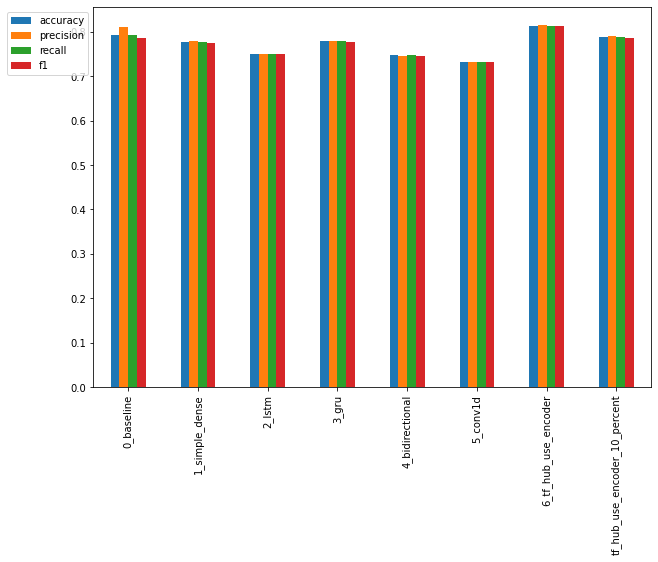

In [105]:
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(0.0,1.0));

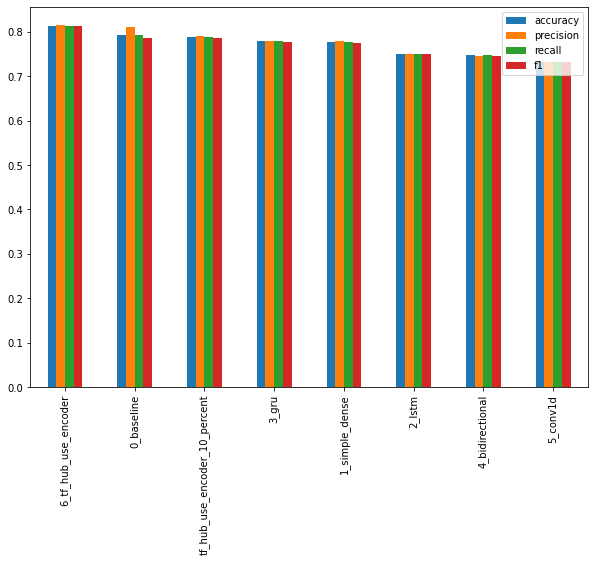

In [106]:
#Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False).plot(kind="bar", figsize=(10,7))

In [107]:
!tensorboard dev upload --logdir ./model_logs/ \
 --name "NLP Modelling Experiment ZTM TF Course Video" \
 --description "Comparing differet architecture on Kaggle Text Classification" \
 --one_shot # exit the uploadr

2021-10-21 03:17:53.038438: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-21 03:17:53.063256: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-21 03:17:53.063891: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./model_logs/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Po

In [108]:
!tensorboard dev list

2021-10-21 03:19:30.273578: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-21 03:19:30.283001: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-21 03:19:30.283679: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

***** TensorBoard Uploader *****

This will list all experiments that you've uploaded to
https://tensorboard.dev. TensorBoard.dev experiments are visible
to everyone. Do not upload sensitive data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.goo

In [109]:
#!tensorboard dev delet --experiment_id   ***put id here*** 

# Saving and loading a model 

In [110]:
#Save TF Hub Sentence Encoder model to HDF5 format
model_6_1.save("model_6_1.h5")

In [111]:
loaded_model_6=tf.keras.models.load_model("model_6_1.h5", 
                                    custom_objects={"KerasLayer": hub.KerasLayer})


In [112]:
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 14ms/step - loss: 0.4303 - accuracy: 0.8136


[0.43033987283706665, 0.8136482834815979]

In [113]:
model_6_1_results

{'accuracy': 81.36482939632546,
 'f1': 0.8121626682144012,
 'precision': 0.8157623872867286,
 'recall': 0.8136482939632546}

In [114]:
model_6_1.save("model_6_1_Saved_Model_format")

INFO:tensorflow:Assets written to: model_6_1_Saved_Model_format/assets


INFO:tensorflow:Assets written to: model_6_1_Saved_Model_format/assets


# Most Wrong Examples

In [115]:
import pandas as pd

pred_df=pd.DataFrame({"text": val_sentences,
                      "y_true": val_labels,
                      "y_pred":model_7_preds,
                      "y_pred_probs":tf.squeeze(model_7_pred_probs)
                      }).sort_values("y_pred_probs", ascending=False)

                     

In [116]:
#Change the dtype of the y_pred 
pred_df["y_pred"]=pred_df["y_pred"].astype("int64")


In [117]:
pred_df



,text,y_true,y_pred,y_pred_probs
734,The Latest: More homes razed by Northern Calif...,1,1,0.938807
166,BBC News - India rail crash: Trains derail in ...,1,1,0.938064
90,Dramatic Video Shows Plane Landing During Viol...,1,1,0.934211
464,Suicide Bomber Kills 13 At Saudi Mosque http:/...,1,1,0.930290
179,beforeitsnews : Hundreds feared dead after Lib...,1,1,0.927232
...,...,...,...,...
484,Holy fuck QVC bitch just got burned so hard.,0,0,0.074045
55,@bentossell @ProductHunt Thanks! I know you al...,0,0,0.070763
309,Damn Wale knows how to ruin a song??,0,0,0.069389
74,@TheBuffShow @TheTwisterOkc My boyfriend wants...,0,0,0.059890


In [118]:
#Show only when y_true != y_pred
mask=pred_df["y_true"]!=pred_df["y_pred"]
pred_df[mask]

,text,y_true,y_pred,y_pred_probs
49,@madonnamking RSPCA site multiple 7 story high...,0,1,0.870234
31,? High Skies - Burning Buildings ? http://t.co...,0,1,0.822194
630,Hollywood movie about trapped miners released ...,0,1,0.784420
80,GENERAL AUDIENCE: On Wounded Families | ZENIT ...,0,1,0.783919
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1,0.782420
...,...,...,...,...
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0,0.121988
681,'The way you move is like a full on rainstorm ...,1,0,0.115097
408,@willienelson We need help! Horses will die!Pl...,1,0,0.114703
382,I wanna set some shit on fire.,1,0,0.098670


In [119]:
val_sentences[49]

'@madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods'

In [120]:
#Download the same model for the video
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip

--2021-10-21 03:19:57--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 74.125.204.128, 64.233.188.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  39.7MB/s    in 18s     

2021-10-21 03:20:16 (51.2 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]



In [121]:
unzip_data("/content/08_model_6_USE_feature_extractor.zip")


In [122]:
model_6_pretrained=tf.keras.models.load_model("08_model_6_USE_feature_extractor")

In [123]:
model_6_pre_pred_probs=model_6_pretrained.predict(val_sentences)

In [124]:
model_6_pretrained_preds=tf.squeeze(tf.round(model_6_pre_pred_probs))
model_6_pretrained_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [125]:
val_df=pd.DataFrame({"text": val_sentences,
                      "target": val_labels,
                      "pred":model_6_pretrained_preds,
                      "y_pred_probs":tf.squeeze(model_6_pre_pred_probs)
                      }).sort_values("y_pred_probs", ascending=False)

In [126]:
val_df

,text,target,pred,y_pred_probs
90,Dramatic Video Shows Plane Landing During Viol...,1,1.0,0.995807
179,beforeitsnews : Hundreds feared dead after Lib...,1,1.0,0.994646
166,BBC News - India rail crash: Trains derail in ...,1,1.0,0.993717
257,USGS reports a M1.94 #earthquake 5km S of Volc...,1,1.0,0.992790
395,The Catastrophic Effects of Hiroshima and Naga...,1,1.0,0.991882
...,...,...,...,...
369,If you fill your mind with encouragement and p...,0,0.0,0.025258
589,my vibrator shaped vape done busted,0,0.0,0.023994
717,Some days I drown in my tears but I don't let ...,0,0.0,0.022529
713,I hate that Im so awkward and I ruin things,0,0.0,0.020455


In [127]:
#Show only when y_true != y_pred
#Change the dtype of the y_pred 
val_df["pred"]=val_df["pred"].astype("int64")
mask=val_df["target"]!=val_df["pred"]
most_wrong=val_df[mask]
most_wrong[:10]

,text,target,pred,y_pred_probs
31,? High Skies - Burning Buildings ? http://t.co...,0,1,0.910196
759,FedEx will no longer transport bioterror patho...,0,1,0.876982
628,@noah_anyname That's where the concentration c...,0,1,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1,0.827213
393,@SonofLiberty357 all illuminated by the bright...,0,1,0.814816
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1,0.810840
49,@madonnamking RSPCA site multiple 7 story high...,0,1,0.803122
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1,0.766901
344,Air Group is here to the rescue! We have 24/7 ...,0,1,0.766625


In [128]:
most_wrong[10:]

,text,target,pred,y_pred_probs
144,The Sound of Arson,0,1,0.762662
381,Deaths 3 http://t.co/nApviyGKYK,0,1,0.747223
1,FedEx no longer to transport bioterror germs i...,0,1,0.747162
698,åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Ten...,0,1,0.742410
695,A look at state actions a year after Ferguson'...,0,1,0.739997
...,...,...,...,...
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0,0.043918
233,I get to smoke my shit in peace,1,0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0,0.038949


In [129]:
val_sentences[759]

'FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J'

In [130]:
for row in most_wrong[-10:].itertuples():

  _, text, target, pred, y_pred_probs=row
  print(f"Target: {target}, Pred: {pred}, Prob: {y_pred_probs}")
  print(f"Text:\n{text}\n")
  print("-----------\n")

Target: 1, Pred: 0, Prob: 0.06730346381664276
Text:
@DavidVonderhaar At least you were sincere ??

-----------

Target: 1, Pred: 0, Prob: 0.05507582053542137
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

-----------

Target: 1, Pred: 0, Prob: 0.05460337549448013
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

-----------

Target: 1, Pred: 0, Prob: 0.054596975445747375
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

-----------

Target: 1, Pred: 0, Prob: 0.04963727295398712
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

-----------

Target: 1, Pred: 0, Prob: 0.043918490409851074
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

-----------



In [131]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [132]:
model_6_pre_test_pred_probs=model_6_pretrained.predict(test_df["text"])

In [133]:
model_6_pretrained_test_preds=tf.squeeze(tf.round(model_6_pre_test_pred_probs))
model_6_pretrained_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [134]:
test_dataframe=pd.DataFrame({"text": test_df["text"],
                      "target": "N.A.",
                      "pred":model_6_pretrained_test_preds,
                      "probs":tf.squeeze(model_6_pre_test_pred_probs)
                      }).sort_values("probs", ascending=False)

In [135]:
test_dataframe

,text,target,pred,probs
548,#DNR\nRes. buildings shelled &amp; on fire in ...,N.A.,1.0,0.996371
2820,The 390-Year-Old Tree That Survived the Bombin...,N.A.,1.0,0.994800
1684,Typhoon Soudelor approaches after 7 killed 2 m...,N.A.,1.0,0.994593
3066,Dramatic Video Shows Plane Landing During Viol...,N.A.,1.0,0.994542
2045,Plane debris is from #MH370 - it was a control...,N.A.,1.0,0.993667
...,...,...,...,...
2662,Just want someone to smoke a blunt &amp; talk ...,N.A.,0.0,0.017012
1808,Would you consider yourself good at giving adv...,N.A.,0.0,0.016693
1199,@_Gags_ My Mommy will be devastated lol #NoMor...,N.A.,0.0,0.016457
438,I would love to #win Suze's amazing filled #be...,N.A.,0.0,0.015200


In [136]:
#Dave visualizing
test_sentences=test_df["text"].to_list()
test_samples=random.sample(test_sentences,10)
for test_sample in test_samples:
  pred_prob=tf.squeeze(model_6_pretrained.predict([test_sample]))
  pred=tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text :\n {test_sample}\n---------\n")

Pred: 1, Prob: 0.9401143193244934
Text :
 Watch This Airport Get Swallowed Up By A Sandstorm In Under A Minute http://t.co/YSrSKuyaSw
---------

Pred: 0, Prob: 0.16330260038375854
Text :
 Spot Flood Combo 53inch 300W Curved Cree LED Work Light Bar 4X4 Offroad Fog Lamp - Full reÛ_ http://t.co/E6BnWxFtkb http://t.co/Ww2uVHRy89
---------

Pred: 0, Prob: 0.02533932402729988
Text :
 Happy birthday bro ?? @Hurricane_Dolce
---------

Pred: 0, Prob: 0.05450071021914482
Text :
 Musician Kalle Mattson Recreates 34 Classic Album Covers in Clever Music Video for 'Avalanche' http://t.co/97eWeUWybf
---------

Pred: 0, Prob: 0.050255730748176575
Text :
 [Brutally Honest Technology ]

Day after day we are inundated with messages issued via machine. Phones.... http://t.co/pB4Vbv01ax
---------

Pred: 0, Prob: 0.4981449246406555
Text :
 The fire brigade should play this guys music at burning buildings to put the flames out
---------

Pred: 1, Prob: 0.8500266671180725
Text :
 Go home California you're dr

In [137]:
#

# The speed / score tradeoff

In [138]:
import time 
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on sample
  """
  start_time=time.perf_counter()#get start time
  model.predict(samples)
  end_time=time.perf_counter()
  total_time=end_time -start_time 
  time_per_pred=total_time/len(samples)
  return total_time, time_per_pred



In [139]:
model_6_total_pred_time, model_6_time_per_pred=pred_timer(model=model_6_pretrained,
                                                          samples=val_sentences)

In [140]:
model_6_total_pred_time, model_6_time_per_pred

(0.36279662200001894, 0.00047611105249346317)

In [141]:
base,base_per_pred=pred_timer(model_0,val_sentences)
base, base_per_pred

(0.03068641699996988, 4.027088845140404e-05)

In [142]:
#Get results for pretrained GS model 
model_6_pretrained_results=calculate_results(y_true=val_labels,
                                             y_pred=model_6_pretrained_preds)
model_6_pretrained_results


{'accuracy': 81.62729658792651,
 'f1': 0.8148082644367335,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651}

In [143]:
model_6_pretrained_results["f1"]

0.8148082644367335

In [144]:
baseline_results["f1"]

0.7862189758049549

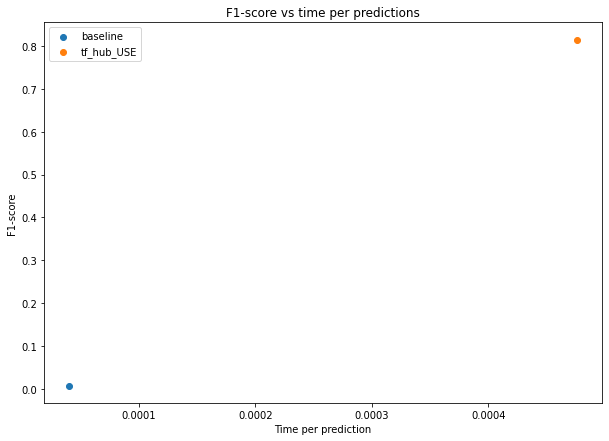

In [145]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.scatter(base_per_pred, baseline_results["f1"]/100, label="baseline")
plt.scatter(model_6_time_per_pred, model_6_pretrained_results["f1"], label="tf_hub_USE")
plt.legend()
plt.title("F1-score vs time per predictions")
plt.xlabel("Time per prediction")
plt.ylabel("F1-score");

# Submission to Kaggle

In [146]:
test_sentences=test_df["text"]
test_sentences[:10]


0                   Just happened a terrible car crash
1    Heard about #earthquake is different cities, s...
2    there is a forest fire at spot pond, geese are...
3             Apocalypse lighting. #Spokane #wildfires
4        Typhoon Soudelor kills 28 in China and Taiwan
5                   We're shaking...It's an earthquake
6    They'd probably still show more life than Arse...
7                                    Hey! How are you?
8                                     What a nice hat?
9                                            Fuck off!
Name: text, dtype: object

In [147]:
# The best model used up to far is model 6
model_6_1_test=model_6_1.predict(test_sentences)

model_6_1_test=tf.cast(tf.squeeze(tf.round(model_6_1_test)), tf.int32)

In [148]:
model_6_1_test.shape

TensorShape([3263])

In [149]:
Submission=pd.DataFrame(test_df['id'], index=None)

In [150]:
Submission["target"]=model_6_1_test

In [151]:
Submission.to_csv("submission.csv", index=False)
#Download files
try:
  from google.colab import files
  files.download('submission.csv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Voting Classifier

In [152]:
import numpy as np
from statistics import mode

# make predictions
models=[model_0,model_1,model_2,model_3,model_4,model_5,model_6_1]
yhats = [tf.cast(tf.squeeze(tf.round(model.predict(test_sentences))), dtype=tf.int32)  for model in models]
yhats = np.array(yhats)


In [153]:
A=pd.DataFrame(yhats).T
A

,0,1,2,3,4,5,6
0,1,1,1,1,1,1,1
1,0,0,0,0,0,0,1
2,1,1,1,1,1,1,1
3,1,0,0,0,0,1,1
4,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...
3258,1,1,1,1,1,1,1
3259,0,1,1,1,1,1,1
3260,1,1,1,1,1,1,1
3261,1,1,1,1,1,1,1


In [154]:
B=A.apply(mode, axis=1)

In [155]:
B.values[:]

array([1, 0, 1, ..., 1, 1, 1])

In [207]:
Submission1=pd.DataFrame(test_df['id'], index=None, dtype=str)

In [208]:
Submission1["target"]=B.values[:].astype(str)

In [209]:
Submission1.to_csv("submission1.csv", index=False)
#Download files
try:
  from google.colab import files
  files.download('submission1.csv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Voting only with the best three models

In [160]:
# make predictions
models=[model_0, model_3,model_6_1]
yhats = [tf.cast(tf.squeeze(tf.round(model.predict(test_sentences))), dtype=tf.int32)  for model in models]
yhats = np.array(yhats)
A=pd.DataFrame(yhats).T
A

,0,1,2
0,1,1,1
1,0,0,1
2,1,1,1
3,1,0,1
4,1,1,1
...,...,...,...
3258,1,1,1
3259,0,1,1
3260,1,1,1
3261,1,1,1


In [211]:
B=A.apply(mode, axis=1)
Submission2=pd.DataFrame(test_df['id'], index=None)
Submission2["target"]=B.values[:]
Submission2.to_csv("submission2.csv", index=False)
#Download files
try:
  from google.colab import files
  files.download('submission2.csv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Ensemble with average of probabilities

In [168]:

model_6_1.predict(test_sentences)
models=[model_1,model_2,model_3,model_4,model_5,model_6_1]
yhats = [tf.squeeze(model.predict(test_sentences))  for model in models]


In [169]:
yhats

[<tf.Tensor: shape=(3263,), dtype=float32, numpy=
 array([0.64612085, 0.01900848, 0.99993193, ..., 0.9714372 , 0.59994495,
        0.9843679 ], dtype=float32)>,
 <tf.Tensor: shape=(3263,), dtype=float32, numpy=
 array([0.99930584, 0.06948837, 0.9996152 , ..., 0.9994918 , 0.6475359 ,
        0.9995598 ], dtype=float32)>,
 <tf.Tensor: shape=(3263,), dtype=float32, numpy=
 array([9.9531168e-01, 1.0920304e-04, 9.9992025e-01, ..., 9.9982256e-01,
        9.9544770e-01, 9.9979025e-01], dtype=float32)>,
 <tf.Tensor: shape=(3263,), dtype=float32, numpy=
 array([9.9901831e-01, 8.6286687e-05, 9.9997759e-01, ..., 9.9987864e-01,
        9.9920952e-01, 9.9993253e-01], dtype=float32)>,
 <tf.Tensor: shape=(3263,), dtype=float32, numpy=
 array([0.8343158 , 0.01393337, 0.84798115, ..., 0.8468329 , 0.82987803,
        0.8468329 ], dtype=float32)>,
 <tf.Tensor: shape=(3263,), dtype=float32, numpy=
 array([0.5803417 , 0.88242394, 0.833266  , ..., 0.92625844, 0.5051442 ,
        0.70362616], dtype=float32)>

In [184]:
average=np.mean(yhats, axis=0)
D=tf.cast(tf.round(average), dtype=tf.int32)

In [185]:
print(D)

tf.Tensor([1 0 1 ... 1 1 1], shape=(3263,), dtype=int32)


In [210]:

Submission3=pd.DataFrame(test_df['id'], index=None)
Submission3["target"]=pd.Series(D)
Submission3.to_csv("submission3.csv", index=False)
#Download files
try:
  from google.colab import files
  files.download('submission3.csv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [193]:
Submission3

,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [ ]:
#The result is still not an improvement 